In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv("/content/Tweets.csv")

In [ ]:
text_column = 'text'
sentiment_column = 'airline_sentiment'

In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove punctuation and special characters
    words = [word for word in words if word.isalnum()]

    # Join words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text


In [ ]:
df['clean_text'] = df[text_column].apply(preprocess_text)


In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))


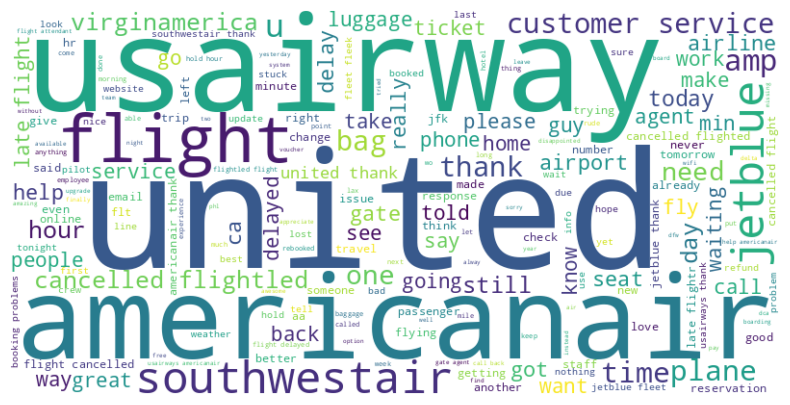

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
import plotly.express as px

In [ ]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [ ]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [ ]:
fig = px.histogram(
    df["airline_sentiment"],
    nbins=25,
    title= "airline sentiment",
    template="plotly_dark",
    labels={"value" :"airline sentiment"},
    color=df["airline_sentiment"]
)
fig.update_traces(
    textfont = {
        "size" : 20,
        "family" :"tahoma",
        "color": "#fff"
    },

)

fig.show()

In [ ]:
review_df = df[df['airline_sentiment'] != 'neutral']

In [ ]:


print(review_df.shape)


(11541, 16)


In [ ]:
review_df = review_df[['clean_text', 'airline_sentiment']]

In [ ]:
print(review_df.shape)

print(review_df['airline_sentiment'].value_counts())

(11541, 2)
airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64


In [ ]:
review_df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

In [ ]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [ ]:
tweet = review_df.clean_text.values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(tweet)

In [ ]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
vocab_size = 10000
embedding_dim = 32

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           320000    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 336651 (1.28 MB)
Trainable params: 336651 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
# Train the model
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)


Epoch 1/5
289/289 [==============================] - 90s 298ms/step - loss: 0.4121 - accuracy: 0.8269 - val_loss: 0.2021 - val_accuracy: 0.9316
Epoch 2/5
289/289 [==============================] - 83s 287ms/step - loss: 0.2108 - accuracy: 0.9196 - val_loss: 0.1732 - val_accuracy: 0.9359
Epoch 3/5
289/289 [==============================] - 80s 276ms/step - loss: 0.1621 - accuracy: 0.9379 - val_loss: 0.1771 - val_accuracy: 0.9355
Epoch 4/5
289/289 [==============================] - 78s 271ms/step - loss: 0.1372 - accuracy: 0.9481 - val_loss: 0.1899 - val_accuracy: 0.9342
Epoch 5/5
289/289 [==============================] - 78s 271ms/step - loss: 0.1140 - accuracy: 0.9578 - val_loss: 0.2057 - val_accuracy: 0.9368


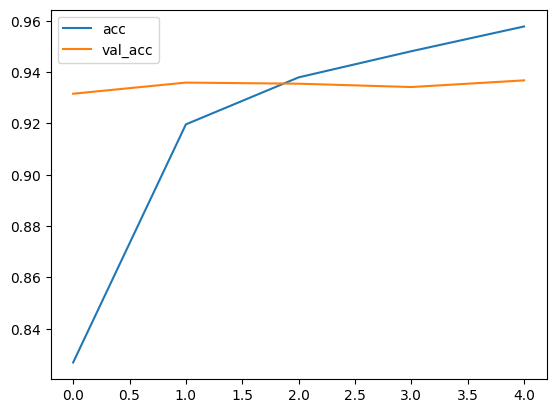

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

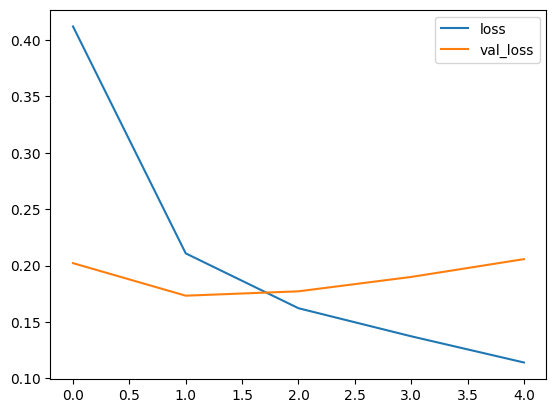

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [ ]:
def predict_sentiment(clean_text):
    tw = tokenizer.texts_to_sequences([clean_text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 303ms/step
Predicted label:  positive
1/1 [==============================] - 0s 42ms/step
Predicted label:  negative


In [ ]:
test_sentence3 = "Great job on the presentation! It was very well done."
predict_sentiment(test_sentence3)

1/1 [==============================] - 0s 38ms/step
Predicted label:  positive


In [ ]:
test_sentence4 = "The flight was delayed for hours, and no explanation was given."
predict_sentiment(test_sentence4)

1/1 [==============================] - 0s 42ms/step
Predicted label:  negative


In [ ]:
test_sentence5 = "I love how smooth and comfortable the flight was."
predict_sentiment(test_sentence5)

1/1 [==============================] - 0s 35ms/step
Predicted label:  positive


In [ ]:
from textblob import TextBlob

def get_sentiment(sentence):
    analysis = TextBlob(str(sentence))
    polarity = analysis.sentiment.polarity

    # Categorize sentiment polarity
    if polarity > 0:
        category = 'positive'
    elif polarity < 0:
        category = 'negative'
    else:
        category = 'neutral'

    return polarity, category

sentence = "I enjoyed my journey on this flight."
polarity, category = get_sentiment(sentence)
print("Sentiment Polarity:", polarity)
print("Sentiment Category:", category)
sentence = "This is the worst flight experience of my life!"
polarity, category = get_sentiment(sentence)
print("Sentiment Polarity:", polarity)
print("Sentiment Category:", category)


Sentiment Polarity: 0.5
Sentiment Category: positive
Sentiment Polarity: -1.0
Sentiment Category: negative
